# Preparing Dataset

upload and check dataset on colab

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from PIL import ImageFile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# title Before run this cell, upload the dataset file to colab first
# cwd = os.getcwd()
# print(cwd)
# !unzip Skin-disease.zip 

# using google drive mounted
from google.colab import drive
drive.mount('/content/drive/')

# extract file
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Skin-disease.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()






Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [56]:
# describe training, validation, and testing directory
base_dir = '../tmp/Skin-disease'

train_dir = os.path.join(base_dir, 'Train')
valid_dir = os.path.join(base_dir, 'Valid')
test_dir = os.path.join(base_dir, 'Test')

# All images will be rescaled by 1./255. and get some augmentation
train_datagen = ImageDataGenerator(rescale = 1.0/255.0 ,
                                   rotation_range=45,
                                   width_shift_range=0.2,      
                                   height_shift_range=0.2,      
                                   shear_range=0.2,      
                                   zoom_range=0.4,      
                                   horizontal_flip=True,      
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale = 1.0/255.0 ,
                                   rotation_range=45,
                                   width_shift_range=0.2,      
                                   height_shift_range=0.2,      
                                   shear_range=0.2,      
                                   zoom_range=0.4,      
                                   horizontal_flip=True,      
                                   fill_mode='nearest')
test_datagen  = ImageDataGenerator(rescale = 1.0/255.0 ,
                                   rotation_range=45,
                                   width_shift_range=0.2,      
                                   height_shift_range=0.2,      
                                   shear_range=0.2,      
                                   zoom_range=0.2,      
                                   horizontal_flip=True,      
                                   fill_mode='nearest')

# --------------------
# Flow training images in batches of 10 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 7,
                                                    class_mode = 'binary',
                                                    target_size = (224,224))
# --------------------
# Flow validation images in batches of 5 using test_datagen generator
# --------------------
validation_generator =  valid_datagen.flow_from_directory(valid_dir,
                                                         batch_size=2,
                                                         class_mode  = 'binary',
                                                         target_size = (224,224))   
# --------------------
# Flow validation images in batches of 5 using test_datagen generator
# --------------------
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                        #  batch_size=5,
                                                         class_mode  = 'binary',
                                                         target_size = (224,224))


Found 140 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


# Building model with Transfer Learning


In [57]:
# using transfer learning to make model
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

IMAGE_SIZE =(224,224)

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,))


model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [58]:
# optimizer = tf.keras.optimizers.SGD(learning_rate=3e-6, momentum=0.09)

# model.compile(optimizer= optimizer,
#                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#                   metrics=['accuracy'])
model.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


# Train model with datset

In [60]:
# adding callbaks to stop epocs when its reaches the accuracy we want
class callbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if ((logs.get('val_accuracy') > 0.8) and logs.get('accuracy') > 0.8):
      self.model.stop_training = True

callbacks = callbacks()

In [62]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=10, callbacks=callbacks)

Epoch 1/10
20/20 [==============================] - 3s 146ms/step - loss: 0.5076 - accuracy: 0.7643 - val_loss: 0.6293 - val_accuracy: 0.7333
Epoch 2/10
20/20 [==============================] - 3s 144ms/step - loss: 0.4551 - accuracy: 0.8214 - val_loss: 0.4623 - val_accuracy: 0.8000


# Model Prediction


Saving 16.JPG to 16.JPG


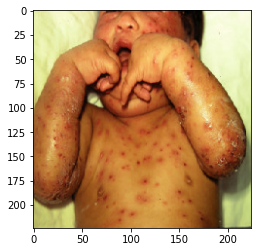

[[0.5770015  0.42299855]]
{'persentase': 57.700151205062866, 'prediksi': 'chickenpox'}


In [66]:
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

# make the label
label = ['chickenpox', 'scabies']

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(224, 224))
  plt.imshow(img)
  plt.show()
  
  x=image.img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  pred_arr = model.predict(images, batch_size=5)

  # choose the big predict
  predict = np.argmax(pred_arr, axis=1)
  
  print(pred_arr)
  data = {
      'persentase' : np.max(pred_arr)*100, 
      'prediksi' : label[predict[0]]}
  print(data)
  

 

# Evaluate train model

Text(0.5, 1.0, 'Training and validation loss')

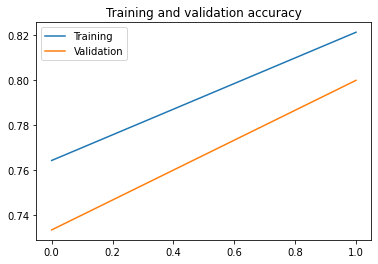

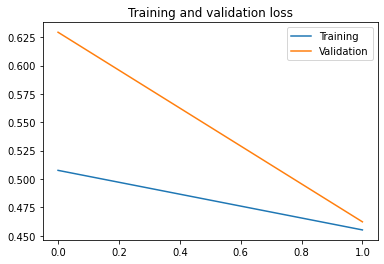

In [67]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs


plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

# Export Model



In [ ]:
two_skin_disease = 'two_skin_disease'

In [ ]:
tf.saved_model.save(model, two_skin_disease)

INFO:tensorflow:Assets written to: two_skin_disease/assets


INFO:tensorflow:Assets written to: two_skin_disease/assets


In [ ]:
%%bash -s $two_skin_disease
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
loaded = tf.saved_model.load(two_skin_disease)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense')}


# Convert to TFLite and Download

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(two_skin_disease)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = '2skin_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [ ]:
class_names = ['chickenpox','scabies']

with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [ ]:
try:
    from google.colab import files
    files.download('2skin_model.tflite')
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Testing model using python intepreter 

In [ ]:
# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]